In [1]:
from itertools import product
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pulp
import warnings
import folium  # For the graph
from geopy.geocoders import Nominatim
from geopy.distance import distance
import random
import time

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import folium
from geopy.geocoders import Nominatim

# Create a geolocator object
geolocator = Nominatim(user_agent="my-app")

# List of major cities in Colombia
cities = ["Bogotá", "Medellín", "Cali", "Barranquilla", "Cartagena", "Cúcuta", 
          "Bucaramanga", "Pereira", "Santa Marta", "Manizales"]

# DataFrame for cities
df_cities = pd.DataFrame(index=cities, columns=["Latitude", "Longitude"])

# Create a new folium map centered on Colombia
m = folium.Map(location=[4.5709, -74.2973], zoom_start=6)

# Loop through the list of cities and geocode each one
for city in cities:
    location = geolocator.geocode(city + ", Colombia")  # Ensure the search is limited to Colombia
    if location is not None:
        print(f"{city}: ({location.latitude}, {location.longitude})")
        df_cities.loc[city, "Latitude"] = location.latitude
        df_cities.loc[city, "Longitude"] = location.longitude
        folium.Marker(location=[location.latitude, location.longitude], popup=city).add_to(m)
    else:
        print(f"Could not geocode {city}")

# Display the map
m

Bogotá: (4.711011, -74.0720917)
Medellín: (6.269732449999999, -75.60255965090315)
Cali: (3.4519988, -76.5325259)
Barranquilla: (11.0101922, -74.8231794084391)
Cartagena: (10.4265566, -75.5441671)
Cúcuta: (8.07761875, -72.46890019811272)
Bucaramanga: (7.16698415, -73.1047294009737)
Pereira: (4.7854606, -75.7883220137654)
Santa Marta: (11.2320944, -74.1950916)
Manizales: (5.0743694, -75.50811667440546)


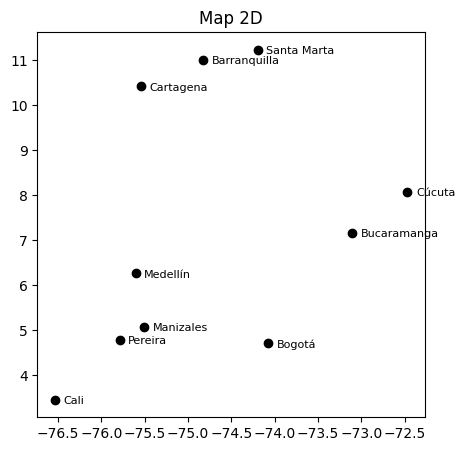

In [ ]:
# check TSP state

plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df_cities.iterrows():
    if i == 'Medellín':  # Berlin will be our starting point
        plt.scatter(row['Longitude'], row['Latitude'], c='r')
        plt.text(row['Longitude'] + 0.1, row['Latitude'] + 0.1, 'Medellín', fontsize=8)
    else:
        plt.scatter(row['Longitude'], row['Latitude'], c='black')
        plt.text(row['Longitude'] + 0.1, row['Latitude'] - 0.1, f'{i}', fontsize=8)

plt.title('Map 2D')
plt.show()

In [21]:
# Select a random route
cities = df_cities.index.tolist()

# Select 5 random cities without repetition
random_route = random.sample(cities, 10)

random_route.append(random_route[0])

print(random_route)

['Cali', 'Manizales', 'Cúcuta', 'Santa Marta', 'Bogotá', 'Barranquilla', 'Pereira', 'Bucaramanga', 'Cartagena', 'Medellín', 'Cali']


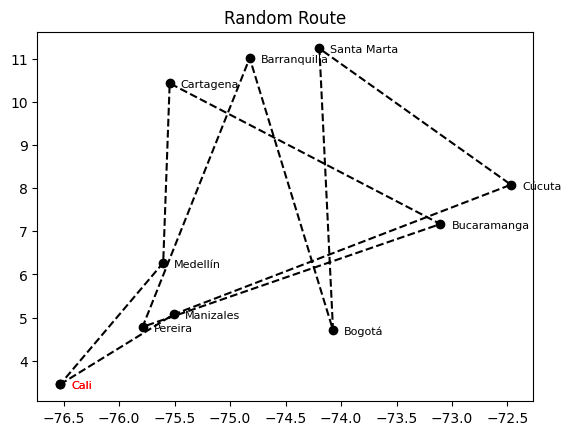

In [22]:
# Plot the random route

plt.plot(df_cities.loc[random_route, 'Longitude'], df_cities.loc[random_route, 'Latitude'], 'o--', c='black')
# Add the name of the city
for i, row in df_cities.loc[random_route].iterrows():
    if i == random_route[0]:
        plt.text(row['Longitude'] + 0.1, row['Latitude'] - 0.1, f'{i}', fontsize=8, c='r')
    else:
        plt.text(row['Longitude'] + 0.1, row['Latitude'] - 0.1, f'{i}', fontsize=8)
plt.title('Random Route')
plt.show()

In [24]:
# Calculation of the distance

dist = np.zeros(len(df_cities[['Latitude', 'Longitude']].values))
for i in range(0, len(df_cities[['Latitude', 'Longitude']].values)):
    l = np.array(
        [distance(df_cities[['Latitude', 'Longitude']].values[i],
                  df_cities[['Latitude', 'Longitude']].values[j]).km for
         j in range(0, len(df_cities[['Latitude', 'Longitude']].values))])
    dist = np.vstack((dist, l))
dist[1:]

array([[  0.        , 241.80991828, 306.62698817, 701.56663467,
        652.63140491, 412.38507825, 291.95233156, 190.57642418,
        721.33820582, 164.268697  ],
       [241.80991828,   0.        , 328.21945319, 531.26162443,
        459.78203787, 399.70794811, 293.44293295, 165.42317965,
        570.25741808, 132.60277425],
       [306.62698817, 328.21945319,   0.        , 856.9074195 ,
        779.01399735, 681.26929072, 559.54014369, 169.0280386 ,
        898.24470104, 212.40851905],
       [701.56663467, 531.26162443, 856.9074195 ,   0.        ,
        101.92106344, 414.72915413, 465.14059902, 696.60168272,
         72.87229454, 660.80738913],
       [652.63140491, 459.78203787, 779.01399735, 101.92106344,
          0.        , 426.21957578, 449.41808044, 624.4557045 ,
        172.34129181, 591.93983454],
       [412.38507825, 399.70794811, 681.26929072, 414.72915413,
        426.21957578,   0.        , 122.73867194, 517.06104777,
        397.00973034, 472.49643075],
       [29

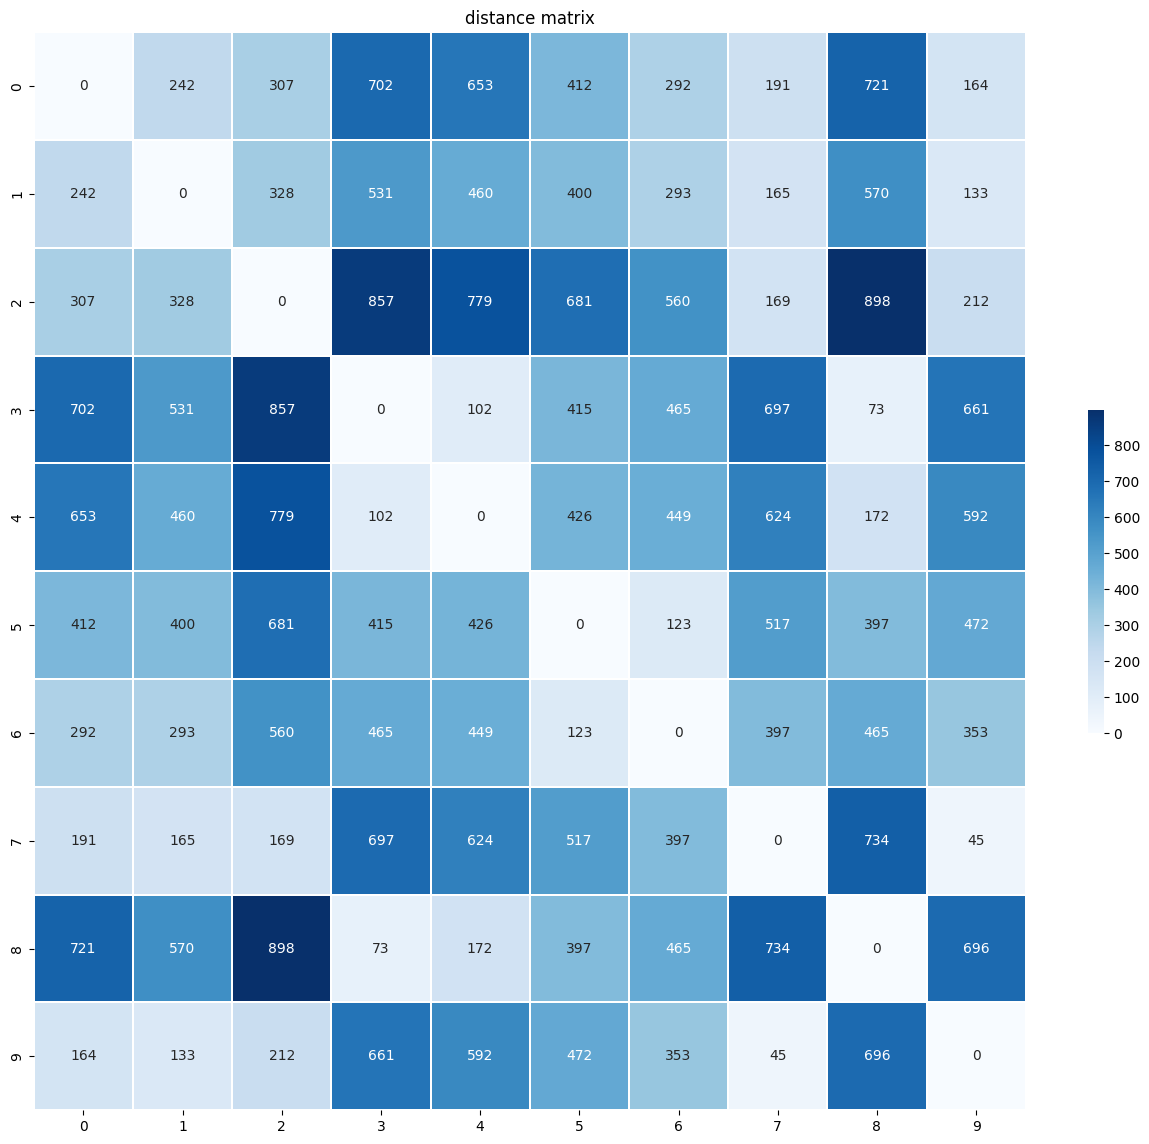

In [26]:
# Get the distance matrix between the cities

# In this case, we have a symmetric problem
distances = pd.DataFrame(dist[1:]).values

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3},
            linewidths=.1)  # Annot is for watch the numbers
plt.title('distance matrix')
plt.show()

In [28]:
%%time

n_point = df_cities.shape[0]

# Set problem
problem = pulp.LpProblem('tsp_mip', pulp.LpMinimize)

# set valiables
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(n_point) for j in range(n_point)), lowBound=0, upBound=1,
                          cat='Binary')
# x[i,j] are binary variables that represent whether we travel from city i to city j in the tour or not
# lowBound=0 and upBound=1 mean that the variables can only take on the values of 0 or 1, respectively

# We need to keep track of the order in the tour to eliminate the possibility of subtours
u = pulp.LpVariable.dicts('u', (i for i in range(n_point)), lowBound=1, upBound=n_point, cat='Integer')
# This line creates another dictionary of decision variables u[i], which are integer variables that represent the position of city i in the tour.

# set objective function
problem += pulp.lpSum(distances[i][j] * x[i, j] for i in range(n_point) for j in range(n_point))
# sets the objective function of the problem to minimize the total distance of the tour, which is calculated by summing the distances between each pair of 
# cities i and j multiplied by the decision variable x[i,j].

# set constrains
for i in range(n_point):
    problem += x[i, i] == 0  # adds a constraint to the problem that we cannot travel from a city to itself.

for i in range(n_point):
    problem += pulp.lpSum(x[i, j] for j in range(
        n_point)) == 1  # adds a constraint to the problem that we must leave each city exactly once.
    problem += pulp.lpSum(x[j, i] for j in range(
        n_point)) == 1  # adds a constraint to the problem that we must arrive at each city exactly once.

# eliminate subtour
for i in range(n_point):
    for j in range(n_point):
        if i != j and (i != 0 and j != 0):
            problem += u[i] - u[j] <= n_point * (1 - x[i, j]) - 1
# adds the subtour elimination constraint that ensures that the solution does not contain any subtours. The constraint ensures that if we travel from city i 
# to city j, then the position of city i in the tour must be less than the position of city j in the tour, unless one of the cities is the starting city.

# solve problem
status = problem.solve()

# output status, value of objective function
status, pulp.LpStatus[status], pulp.value(problem.objective)

CPU times: total: 15.6 ms
Wall time: 362 ms


(1, 'Optimal', 2099.1042288228277)

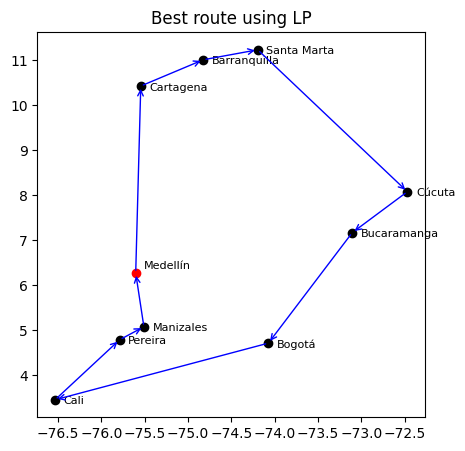

In [30]:
# check TSP problem and optimized route

plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df_cities.iterrows():
    if i == 'Medellín':
        plt.scatter(row['Longitude'], row['Latitude'], c='r')
        plt.text(row['Longitude'] + 0.1, row['Latitude'] + 0.1, 'Medellín', fontsize=8)
    else:
        plt.scatter(row['Longitude'], row['Latitude'], c='black')
        plt.text(row['Longitude'] + 0.1, row['Latitude'] - 0.1, f'{i}', fontsize=8)

plt.title('Best route using LP')

# draw optimal route
#routes = [(i, j) for i in range(n_point) for j in range(n_point) if
#          pulp.value(x[i, j]) == 1]  # With the condition in the comprehension list we do the

tol = 1e-6
routes = [(i, j) for i in range(n_point) for j in range(n_point) if 1 - pulp.value(x[i, j]) < tol]

# program only select the correct route
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in routes:
    plt.annotate('', xy=[df_cities.iloc[j]['Longitude'], df_cities.iloc[j]['Latitude']],
                 xytext=[df_cities.iloc[i]['Longitude'], df_cities.iloc[i]['Latitude']], arrowprops=arrowprops)
# This code block iterates over all pairs of cities in the routes list and adds an arrow between them to represent the optimal route. It uses the 
# plt.annotate() method from matplotlib to create the arrow. The xy parameter specifies the coordinates of the end point of the arrow, and the xytext 
# parameter specifies the coordinates of the start point of the arrow. The arrowprops parameter specifies the properties of the arrow.

plt.show()